In [ ]:
import numpy as np
import random
from time import sleep
from tqdm import tqdm
from scipy import linalg as LA
from matplotlib import pyplot as plt 
from scipy.stats import mstats

random.seed(10)
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

def excl_max(arr,indices):
    mask = np.zeros(arr.size, dtype=bool)
    mask[indices] = True
    a = np.ma.array(arr, mask=mask)
    return np.max(a)

In [ ]:
def ucb(n, z, t, avail):
    if 0 in n[avail==1]: # some arm is available and has not been pulled yet
        iaux = random.randint(0,np.sum((n==0)*(avail==1))-1)
        choice = np.where((n==0)*(avail==1))[0][iaux] # select one of these arms at random
    else:
        lmin = np.min((z/np.maximum(n,1)-np.sqrt(8*np.log(t+1)/np.maximum(n,1)))[avail==1])
        aux = (z/np.maximum(n,1)-np.sqrt(8*np.log(t+1)/np.maximum(n,1)) == lmin)*(avail==1)
        iaux = random.randint(0,np.sum(aux)-1)
        choice = np.where(aux)[0][iaux]

    
    return choice

def ucb_update(n, z, loss, choice):
        
    z[choice]+=loss[choice]
    n[choice]+=1
    
    return n, z

In [ ]:
def SIEXP3(L, eta, avail):
    
    K = len(L)
    k = np.sum(avail)
    
    if k>1:
        idx = np.array(np.where(avail>0)).reshape(k,1)
        M = L[idx,idx.T]
        
        min_loss = 0
        if len(np.where(M>0)[0])>0:
            min_loss = np.min(M[np.where(M>0)])

        # define the exponential matrix Q
        Q = np.zeros((k,k))
        for i in range(k):
            for j in range(k):
                if i!=j:
                    Q[i][j]=np.exp(-eta*(M[i][j] - min_loss))

        # normalize entries
        Qt=np.zeros((k,k))
        for i in range(k):
            for j in range(k):
                Qt[i][j]=Q[i][j]/np.sum(Q[j])

        v, w = LA.eig(np.transpose(Qt))
        w=np.transpose(w)

        probs=np.absolute(np.real(w[np.argmin(np.absolute(v - 1))]))
    else:
        probs = 1
    
    p = np.zeros(K)
    p[np.where(avail>0)] = probs/np.sum(probs)
    
    choice=np.random.choice(a=K,size=1,p=p)
    return p,choice

def SIEXP3_update(L,loss,p,choice):
    expert_probs=np.zeros((K,K,K))
    for i in range(K):
        for j in range(K):
            if i!=j:
                temp=p.copy()
                temp[i]=0
                temp[j]=p[i]+p[j]
                expert_probs[i][j]=temp

    est_loss=np.zeros(K)
    est_loss[choice]=loss[choice]/p[choice]
    
    expert_loss=np.zeros((K,K))
    for i in range(K):
        for j in range(K):
            if i!=j:
                if avail[j] == 1:
                    expert_loss[i][j]=np.dot(expert_probs[i][j],est_loss)
                else:
                    expert_loss[i][j]=loss[choice]

    L+=expert_loss
    return L

In [ ]:
T = 50000
K = 4
niter = 10
sampling_rules = ["Sp-UCB","Sp-SI-EXP3"]#,"S-EXP3"]

regret = np.zeros((len(sampling_rules),niter,T))

for iter in tqdm(range(niter)):
    L1=np.zeros((K,K))
    L2=np.zeros((K,K))
    n1=np.zeros(K)
    z1=np.zeros(K)
    n2=np.zeros(K)
    z2=np.zeros(K)


    thetas=[]
    for i in range(K):
        thetas=[np.array([1,2,3,4]),np.array([4,1,2,3]),np.array([3,4,1,2]),np.array([2,3,4,1])]
        #thetas.append(np.random.uniform(low=1,high=100,size=K))
        #[0,1,1,1], [1,0,1,1]...


    avails=[]
    for i in range(K):
        temp=np.ones(K,dtype='int')
        temp[i]=0
        avails.append(temp)
    
    prefs=[]
    for i in range(K):
        prefs.append(np.zeros((K,K)))

    for h in range(K):
        for i in range(K):
            for j in range(K):
                prefs[h][i][j]=thetas[h][i]/(thetas[h][i]+thetas[h][j])




    ### FOR UCB
    loss1=np.zeros(K)
    loss2=np.zeros(K)


    choices=[]
    for t in range(T):
        choices.append(random.randint(0,K-1))

    for t in range(T):
        avail=np.copy(avails[choices[t]])
        pref=prefs[choices[t]]
        choice1 = ucb(n1, z1, t, avail)
        avail_mod=avail
        avail_mod[choice1]=0
        #print(A,choices[t],avail,avail_mod)
        choice2 = ucb(n2, z2, t, avail_mod)
        loss1=np.random.binomial(n=1,p=pref[choice2],size=K)
        loss2=np.random.binomial(n=1,p=pref[choice1],size=K) 
        n1,z1=ucb_update(n1,z1,loss1,choice1)
        n2,z2=ucb_update(n2,z2,loss2,choice2)       
        regret[0,iter,t]=(excl_max(np.squeeze(pref[:,[choice1]],1),[choice1,choices[t]])+excl_max(np.squeeze(pref[:,[choice2]],1),[choice2,choices[t]])-1)/2.0
    regret[0,iter,:]=np.cumsum(regret[0,iter,:])

    ### FOR SI_EXP3
    loss1=np.zeros(K)
    loss2=np.zeros(K)

    for t in range(T):
        eta = 1/(t+1)**0.5
        avail=np.copy(avails[choices[t]])
        pref=prefs[choices[t]]
        p1,choice1 = SIEXP3(L1, eta, avail)
        choice1=choice1[0]
        avail_mod=avail
        avail_mod[choice1]=0
        p2,choice2 = SIEXP3(L2, eta, avail_mod)
        choice2=choice2[0]
        loss1=np.random.binomial(n=1,p=pref[choice2],size=K)
        loss2=np.random.binomial(n=1,p=pref[choice1],size=K)
        L1=SIEXP3_update(L1,loss1,p1,choice1)
        L2=SIEXP3_update(L2,loss2,p2,choice2)
        regret[1,iter,t]=(excl_max(np.squeeze(pref[:,[choice1]],1),[choice1,choices[t]])+excl_max(np.squeeze(pref[:,[choice2]],1),[choice2,choices[t]])-1)/2.0
    regret[1,iter,:]=np.cumsum(regret[1,iter,:])

100%|██████████| 10/10 [10:56<00:00, 65.66s/it]


In [ ]:
T = 50000
K = 4
niter = 5
sampling_rules = ["Sp-UCB","Sp-SI-EXP3"]#,"S-EXP3"]

regret = np.zeros((len(sampling_rules),niter,T))

for iter in tqdm(range(niter)):
    L1=np.zeros((K,K))
    L2=np.zeros((K,K))
    n1=np.zeros(K)
    z1=np.zeros(K)
    n2=np.zeros(K)
    z2=np.zeros(K)

    
    theta = np.random.uniform(low=1,high=50,size=K) #np.array([1,2,3,10])
    pref=np.zeros((K,K))
    for i in range(K):
        for j in range(K):
            pref[i][j]=theta[i]/(theta[i]+theta[j])
    

    # sample A1 or A2...
    # pref = pref1 or pref2

    '''
    pref=np.random.rand(K,K)
    pref=np.triu(pref)
    pref=pref+np.tril(1-pref.T)
    np.fill_diagonal(pref, 0.5)
    '''
    ### FOR UCB
    loss1=np.zeros(K)
    loss2=np.zeros(K)


    for t in range(T):
        avail=np.ones(K,dtype=int)
        choice1 = ucb(n1, z1, t, avail)
        avail_mod=avail
        avail_mod[choice1]=0
        choice2 = ucb(n2, z2, t, avail_mod)
        loss1=np.random.binomial(n=1,p=pref[choice2],size=K)
        loss2=np.random.binomial(n=1,p=pref[choice1],size=K) 
        n1,z1=ucb_update(n1,z1,loss1,choice1)
        n2,z2=ucb_update(n2,z2,loss2,choice2)       
        regret[0,iter,t]=(excl_max(np.squeeze(pref[:,[choice1]],1),[choice1])+excl_max(np.squeeze(pref[:,[choice2]],1),[choice2])-1)/2.0
    regret[0,iter,:]=np.cumsum(regret[0,iter,:])

    ### FOR SI_EXP3
    loss1=np.zeros(K)
    loss2=np.zeros(K)

    for t in range(T):
        eta = 1/(t+1)**0.5
        avail=np.ones(K,dtype=int)
        p1,choice1 = SIEXP3(L1, eta, avail)
        choice1=choice1[0]
        avail_mod=avail
        avail_mod[choice1]=0
        p2,choice2 = SIEXP3(L2, eta, avail_mod)
        choice2=choice2[0]
        loss1=np.random.binomial(n=1,p=pref[choice2],size=K)
        loss2=np.random.binomial(n=1,p=pref[choice1],size=K)
        L1=SIEXP3_update(L1,loss1,p1,choice1)
        L2=SIEXP3_update(L2,loss2,p2,choice2)
        regret[1,iter,t]=(excl_max(np.squeeze(pref[:,[choice1]],1),[choice1])+excl_max(np.squeeze(pref[:,[choice2]],1),[choice2])-1)/2.0
    regret[1,iter,:]=np.cumsum(regret[1,iter,:])

100%|██████████| 5/5 [06:00<00:00, 72.08s/it]


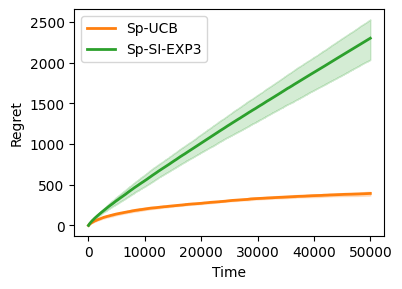

In [ ]:
T_plot = T
fig=plt.figure(figsize=(4,3), dpi= 100, facecolor='w', edgecolor='k')
for i in range(2):
    means = np.mean(regret[i,:,:], axis=0)
    quantiles = mstats.mquantiles(regret[i,:,:], axis=0)
    plt.plot(np.arange(T_plot-1),means[1:T_plot], label=sampling_rules[i], color = colors[i+1], linewidth=2)
    plt.fill_between(np.arange(T_plot-1), quantiles[0,1:T_plot] ,quantiles[2,1:T_plot], color= colors[i+1], alpha=.2)
plt.xlabel("Time")
plt.ylabel('Regret')
plt.legend()
plt.savefig('exp1.pdf', bbox_inches = "tight")
plt.show()

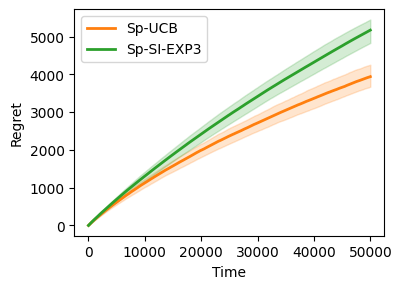

In [ ]:
T_plot = T
fig=plt.figure(figsize=(4,3), dpi= 100, facecolor='w', edgecolor='k')
for i in range(2):
    means = np.mean(regret[i,:,:], axis=0)
    quantiles = mstats.mquantiles(regret[i,:,:], axis=0)
    plt.plot(np.arange(T_plot-1),means[1:T_plot], label=sampling_rules[i], color = colors[i+1], linewidth=2)
    plt.fill_between(np.arange(T_plot-1), quantiles[0,1:T_plot] ,quantiles[2,1:T_plot], color= colors[i+1], alpha=.2)
plt.xlabel("Time")
plt.ylabel('Regret')
plt.legend()
plt.savefig('exp1.pdf', bbox_inches = "tight")
plt.show()

In [ ]:
T_plot = T
fig=plt.figure(figsize=(4,3), dpi= 100, facecolor='w', edgecolor='k')
for i in range(2):
    means = np.mean(regret[i,:,:], axis=0)
    quantiles = mstats.mquantiles(regret[i,:,:], axis=0)
    plt.plot(np.arange(T_plot-1),means[1:T_plot], label=sampling_rules[i], color = colors[i+1], linewidth=2)
    plt.fill_between(np.arange(T_plot-1), quantiles[0,1:T_plot] ,quantiles[2,1:T_plot], color= colors[i+1], alpha=.2)
plt.xlabel("Time")
plt.ylabel('Regret')
plt.legend()
plt.savefig('exp1.pdf', bbox_inches = "tight")
plt.show()